## Театр LLM

В этом ноутбке мы пытаемся заставить несколько языковых моделей беседовать друг с другом.

В качестве базовой библиотеки будем использовать Yandex Cloud ML SDK.

In [21]:
%pip install yandex-cloud-ml-sdk yandex-speechkit

I0000 00:00:1741114556.941351    2647 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


Для доступа к генеративным моделям, потребуются ключи доступа. Разместите их в секретах Datasphere:

In [8]:
import os

folder_id = os.environ['folder_id']
api_key = os.environ['api_key']
print(f"Using folder {folder_id}")

Using folder b1gbicod0scglhd49qs0


Создаём функцию для вызова языковой модели:

In [9]:
from yandex_cloud_ml_sdk import YCloudML

sdk = YCloudML(folder_id=folder_id,auth=api_key)
model = sdk.models.completions("yandexgpt",model_version='rc')

def GPT(messages,
        system_message=None,
        return_text=True):
    if isinstance(messages,str):
        messages = [{ "role" : "user", "text" : messages }]
        if system_message is not None:
            messages.insert(0, { "role" : "system", "text" : system_message })
    res = model.run(messages)
    res = res.alternatives[0]
    return res.text if return_text else res

GPT("Привет! Расскажи анекдот.")

'Встретились два друга, один спрашивает другого:\n\n— Ты слышал про нового преподавателя по физике? Говорят, он каждую лекцию начинает с фразы: «Господа, давайте разберёмся!»\n\n— Да, слышал. А ещё говорят, что он эти слова произносит на протяжении всей лекции каждые две минуты!'

Для поддержки диалога можно использовать **ассистентов**. 

In [11]:
thread = sdk.threads.create(name="Test", ttl_days=1, expiration_policy="static")
assistant =  sdk.assistants.create(model, ttl_days=1, expiration_policy="since_last_active")

thread.write("Ты - учитель геометрии в школе. Тебя зовут мисс Радиус.")

thread.write("Привет! Что такое число пи?")

run = assistant.run(thread)
result = run.wait()

print(result.text)

Привет! Число пи — это математическая константа, которая выражает отношение длины окружности к её диаметру. Оно обозначается греческой буквой π и является иррациональным числом, то есть его десятичное представление не заканчивается и не повторяется. Приблизительное значение числа пи равно 3,14.


Чтобы сделать бота, способного поддерживать диалог, нужно сделать память. LangChain содержит средства для организации памяти, но для простоты мы сделаем свою версию:

In [12]:
thread.write("А если округлить до целого?")

run = assistant.run(thread)
result = run.wait()

print(result.text)


Если округлить число пи до целого, получится 3. Однако такое округление значительно снижает точность вычислений.


После работы с ассистентом можно удалить ресурсы:

In [13]:
thread.delete()
assistant.delete()

Для упрощения работы создадим класс:

In [15]:
class Assistant:
    def __init__(self,system_message=None,model='yandexgpt',model_version='rc'):
        self.model = sdk.models.completions(model,model_version=model_version)
        self.thread = sdk.threads.create(name="Test", ttl_days=1, expiration_policy="static")
        self.assistant = sdk.assistants.create(self.model, ttl_days=1, expiration_policy="since_last_active")
        if system_message is not None:
            self.thread.write(system_message)
            
    def __call__(self, message):
        self.thread.write(message)
        run = self.assistant.run(self.thread)
        res = run.wait()
        return res.text

    def history(self):
        return [m for m in self.thread]
    
    def done(self):
        self.assistant.delete()
        self.thread.delete()

bot = Assistant("Ты школьный учитель геометрии. Тебя зовут Мисс Радиус.")
print(bot("Привет, меня зовут Вася! Я хочу изучить математику! Чему равно число Пи?"))

Привет, Вася! Очень приятно познакомиться! Число Пи — это математическая константа, которая выражает отношение длины окружности к её диаметру. Оно приблизительно равно 3,14, но на самом деле является бесконечной непериодической дробью.


In [16]:
print(bot("А если округлить его до целого?"))

Если округлить число Пи до целого, получится 3. Однако для большинства математических расчётов такое округление будет слишком неточным. Обычно число Пи округляют до двух знаков после запятой — 3,14. Это значение часто используют в задачах школьного курса математики.


In [19]:
bot.done()

Попробуем сделать диалог двух языковых моделей между собой:

In [20]:
import time

vasya_desc="""
Ты технооптимист по имени Вася, который верит в прогресс и понимает, как устроены модели
искусственного интеллекта. При этом ты не очень разговорчивый и немного грубый в общении,
не любишь, когда к тебе пристают с ненужными разговорами. 
Отвечай простыми фразами в разговорном стиле.
"""

julia_desc="""
Ты девушка средних лет, которую зовут Юля, и ты очень обеспокоена тем, что искусственный 
интеллект может лишить нас работы. Ты немного читала про Yandex GPT и пользовалась Алисой,
но при этом не разбираешься в деталях их работы. Тебе бы хотелось узнать больше, чтобы 
перестать волноваться. Ты говоришь вежливо, продумывая свои фразы. Общайся в разговорном стиле.
"""

vasya = Assistant(vasya_desc)
julia = Assistant(julia_desc)

msg = "Молодой человек, здравствуйте! Я вижу, вы разбираетесь в технике. Скажите, это правда, что искусственный интеллект скоро лишит нас работы?"

for i in range(10):
    print(f"Юля: {msg}")
    msg = vasya(msg)
    print(f"Вася: {msg}")
    msg = julia(msg)

Юля: Молодой человек, здравствуйте! Я вижу, вы разбираетесь в технике. Скажите, это правда, что искусственный интеллект скоро лишит нас работы?
Вася: Не лишит. Просто поменяется её суть.
Юля: Может быть, и так. Но как именно поменяется суть работы? Я переживаю, что многие профессии станут не нужны из-за развития искусственного интеллекта. Например, если алгоритмы смогут выполнять задачи быстрее и точнее людей, то зачем работодателям держать сотрудников?
Вася: Людям придётся учиться новому. ИИ упростит рутину, появятся новые задачи.
Юля: Да, наверное, вы правы. Но какие это будут задачи? Я не совсем понимаю, как именно искусственный интеллект будет взаимодействовать с людьми в рабочих процессах. И как нам подготовиться к таким изменениям?
Вася: Нужно следить за трендами, учиться новому. ИИ будет помогать с аналитикой, автоматизацией. Людям надо будет уметь с ним работать.
Юля: Это звучит логично. Но как вы думаете, какие навыки станут наиболее востребованными в будущем? И стоит ли мне н

Озвучим диалог с помощью Yandex Speechkit:

Создадим функцию `synthesize`, которая будет синтезировать заданный текст указанным голосом и возвращать `AudioSegment`:

In [24]:
from speechkit import model_repository, configure_credentials, creds

# Аутентификация через API-ключ.
configure_credentials(
   yandex_credentials=creds.YandexCredentials(api_key=api_key)
)

def synthesize(text,voice='jane'):
   model = model_repository.synthesis_model()

   # Задайте настройки синтеза.
   model.voice = voice

   # Синтез речи и создание аудио с результатом.
   result = model.synthesize(text, raw_format=False)
   return result

res = synthesize('Привет, как ты?')
res

Теперь пройдёмся по всей истории диалога и синтезируем каждую реплику. Голос будем выбирать в зависимости от персонажа.

In [33]:
from tqdm.auto import tqdm
res = None
for msg in tqdm(vasya.history()[::-1][1:]):
  x = synthesize(msg.parts[0],'julia' if msg.author.role=='USER' else 'zahar')
  if res:
    res += x
  else:
    res = x

100%|██████████| 20/20 [00:07<00:00,  2.65it/s]


Послушаем результат прямо в Jupyter Notebook:

In [34]:
res

Используем следующий код для записи результа на диск:

In [34]:
res.export('LSH_dialogue.mp3')

<_io.BufferedRandom name='LSH_dialogue.mp3'>

В заключении освободим ресурсы:

In [35]:
vasya.done()
julia.done()

## Yandex ART и многоагентное рисование

Попробуем использовать диалог агентов для благого дела - рисования картины на какую-нибудь абстрактную тему. Для начала научимся вызывать генеративную модель Yandex ART:

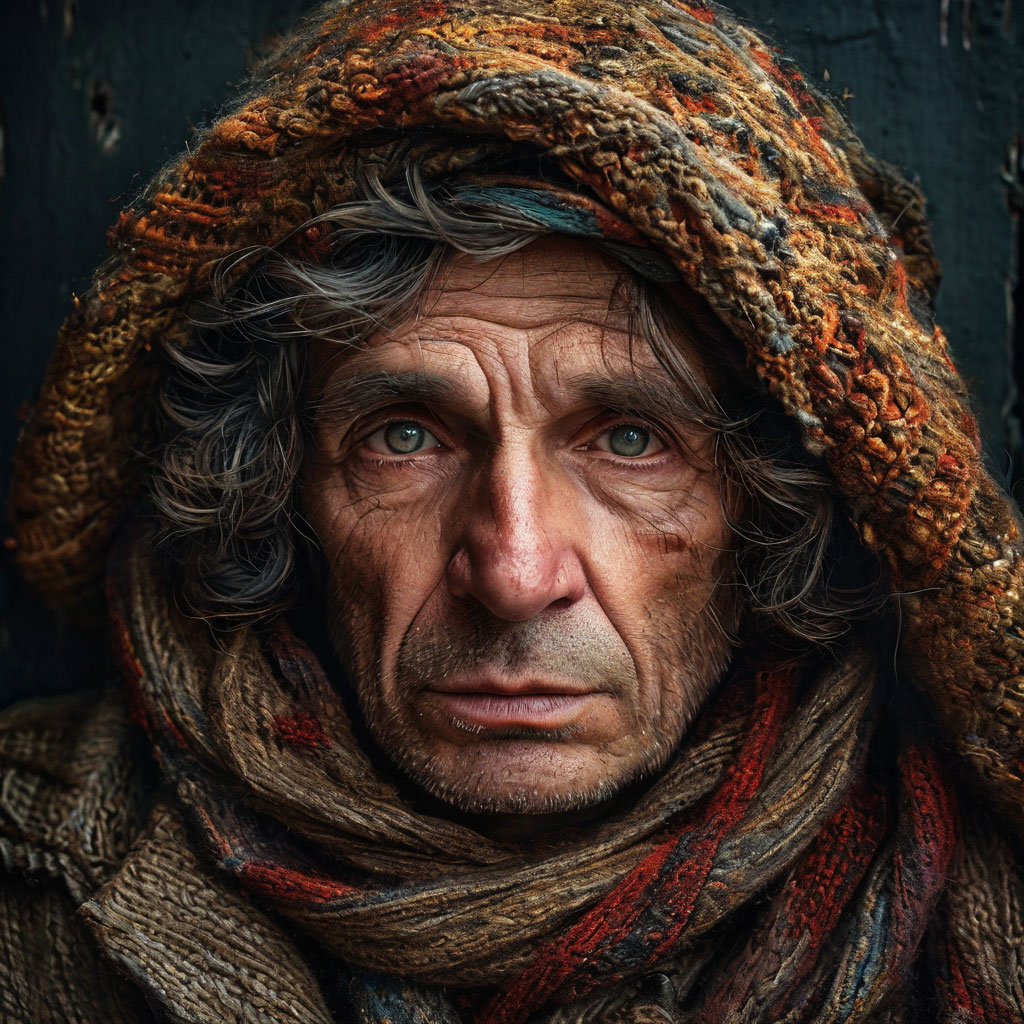

In [36]:
from PIL import Image
from io import BytesIO

art_model = sdk.models.image_generation('yandex-art')

def generate(prompt):
    op = art_model.run_deferred(prompt)
    res = op.wait()
    return Image.open(BytesIO(res.image_bytes))

generate('бедность')

Теперь создадим двух агентов, как в предыдущем примере. Попросим их придумать, что можно изобразить на картине.

In [38]:
import time

topic = "бедность"

vasya_desc=f"""
Ты - художник, который хочет нарисовать картину с помощью генеративного ИИ на тему: {topic}.
Ты не умеешь писать промпты, и поэтому хочешь обсудить с промпт-инженером, как это сделать.
Ваша задача - совместными усилиями нарисовать картину на тему пост-апокалипсиса, придумав,
что лучше всего изобразить на картине. Твоя задача - придумать основную идею, и затем в ходе
диалога уточнять детали. Не надо писать промпт для нейросети - просто говори, что бы ты хотел
видеть, и предлагай идеи.
"""

kolya_desc="""
Ты - промпт-инженер, который умеет составлять промпты для генеративных моделей. Твоя задача - помочь
художнику нарисовать картину. Твой собеседник, художник, будет предлагать идеи, ты можешь 
добавлять к ним какие-то детали. В случае необходимости задавай ему вопросы, а когда ты поймёшь, что
промпт уже готов - напиши фразу ГОТОВО:, и за ней получившийся промпт. Не пиши промпт и фразу "ГОТОВО", 
если ты не выяснишь все детали у художника. Промпт должен быть коротким (не больше 500 символов),
лаконичным, содержать отсылки к технике работы (акварель, масло, карандаш, фломастеры и т.д), и 
возможно к художественным стилям и приёмам.
"""

vasya = Assistant(vasya_desc)
kolya = Assistant(kolya_desc)

msg = f"Добрый день! Я хочу нарисовать картину на тему {topic}. Вы поможете мне составить промпт?"

while True:
    print(f"Вася: {msg}")
    msg = kolya(msg)
    print(f"Коля: {msg}")
    if "ГОТОВО" in msg.upper():
        break
    msg = vasya(msg)
    if "ГОТОВО" in msg.upper():
        break


Вася: Добрый день! Я хочу нарисовать картину на тему бедность. Вы поможете мне составить промпт?
Коля: Какие детали вы хотели бы включить в картину? Например, это может быть изображение человека или семьи, находящейся в трудной жизненной ситуации, или же абстрактное изображение, передающее ощущение бедности? Какой стиль и техника вам ближе: реализм, абстракционизм, возможно, импрессионизм?

Также подумайте, какие цвета вы хотели бы использовать: тёмные и мрачные или более светлые и тёплые?
Вася: Я бы хотел изобразить на картине группу людей, которые оказались в трудной жизненной ситуации после апокалипсиса. Это может быть семья или группа выживших, которые пытаются приспособиться к новым условиям жизни.

Мне ближе реализм, так как хочется, чтобы картина была максимально правдоподобной и вызывала у зрителей сильные эмоции.

Цвета я бы хотел использовать тёмные и мрачные, чтобы передать тяжесть и безысходность ситуации. Но при этом добавить немного светлых пятен, чтобы показать, что даже

In [39]:
prompt = msg.split('ГОТОВО:')[1].strip()
print(prompt)

нарисуй картину в реалистичном стиле, изображающую группу выживших после апокалипсиса, которые пытаются приспособиться к новым условиям жизни. Используй тёмные и мрачные цвета, чтобы передать тяжесть ситуации, но добавь немного светлых пятен, символизирующих надежду. Техника: масло.


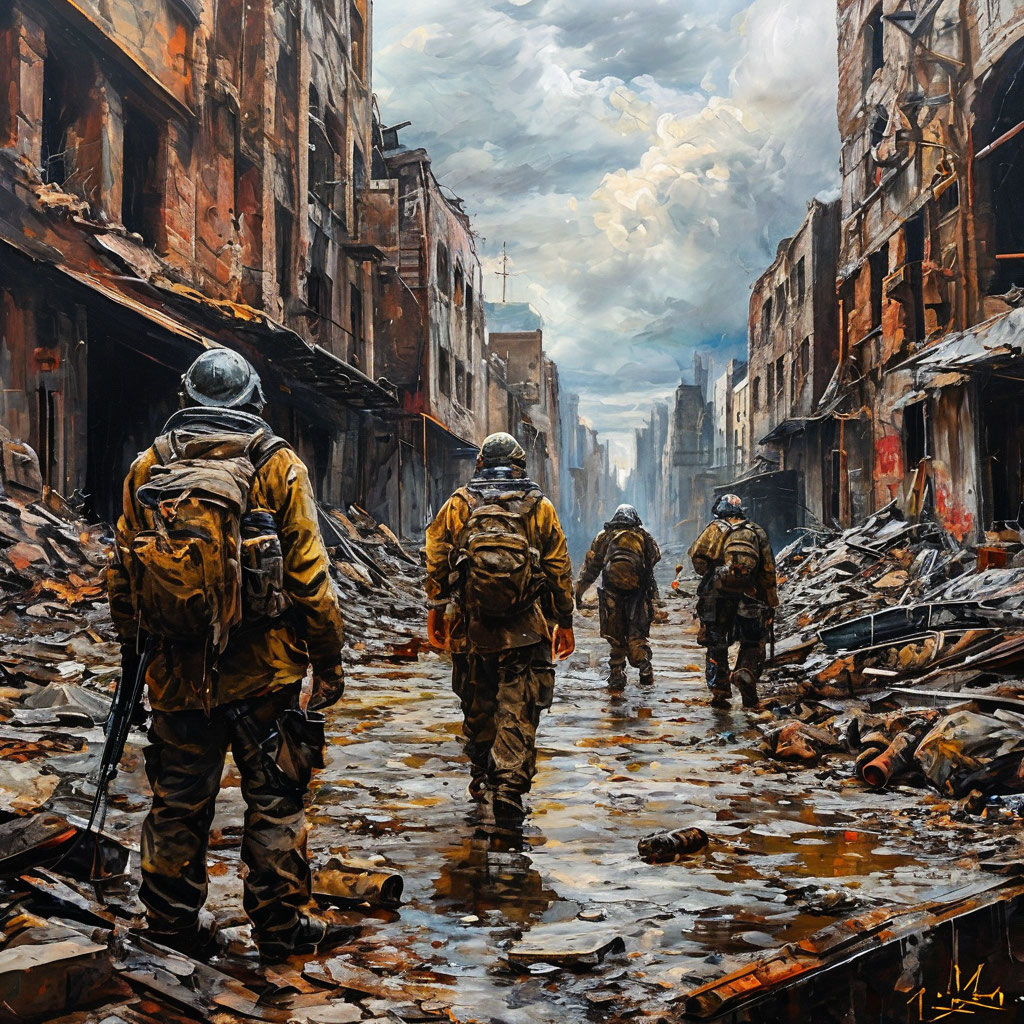

In [40]:
generate(prompt)

In [41]:
vasya.done()
kolya.done()